***Датасет взят с:*** https://www.kaggle.com/datasets/simranjain17/insurance

# Задание:

Построить оптимальную модель *RandomForestRegressor*, предсказывающую размер страховой премии по характеристикам клиента (страхователя).

# Импортируем необходимые библиотеки:

In [172]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from  sklearn.model_selection import train_test_split
from  sklearn.ensemble import RandomForestRegressor
from  sklearn.model_selection import cross_val_score
from  sklearn.model_selection import GridSearchCV



from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.model_selection import cross_val_score

sns.set_theme()

# Импортируем исходный датасет:

        1. Производим импорт:

*ЗНАЧЕНИЯ КОЛОНОК:*

1) ***age*** - Возраст страхователя.

2) ***sex*** - Пол страхователя. 

3) ***bmi*** - Индекс массы тела страхователя.

4) ***children*** - Количество детей страхователя.

5) ***smoker*** - является ли страхователь курильщиком или некурящим.

6) ***region*** - Регион, к которому относится Страхователь.

7) ***charges*** - Премия, взимаемая со страхователя (целевая переменная).

In [215]:
path = r"D:\insurance\insurance.csv"

df = pd.read_csv(path)

df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [107]:
x = pd.DataFrame({
        'age':      age_widget.value,
        'sex':      sex_widget.value,
        'bmi':      bmi_widget.value,
        'children': children_widget.value,
        'smoker':   smoker_widget.value,
        'region':   region_widget.value
    }, index=[0])

    2. Смотрим характеристики датафрейма:

In [97]:
# Размер:
df.shape

(1338, 7)

In [98]:
# Типы данных столбцов:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [99]:
# Кол-во уник. значений столбцов:
for col in df.columns:
    print(f'Столбец {col}: {df[col].nunique()} уник. значения')

Столбец age: 47 уник. значения
Столбец sex: 2 уник. значения
Столбец bmi: 548 уник. значения
Столбец children: 6 уник. значения
Столбец smoker: 2 уник. значения
Столбец region: 4 уник. значения
Столбец charges: 1337 уник. значения


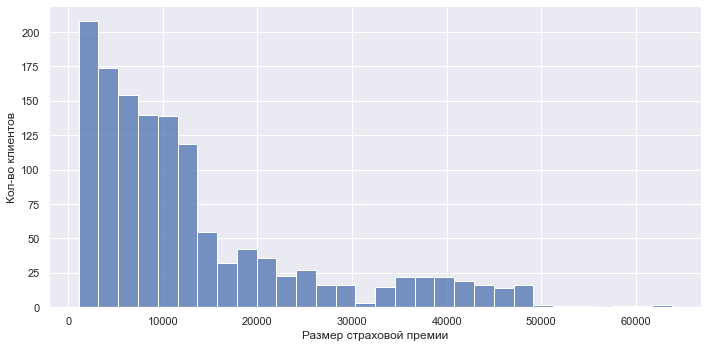

In [217]:
# Распределение значений страховых премий:
sns.displot(data=df, x='charges', aspect=2).set(xlabel='Размер страховой премии', ylabel='Кол-во клиентов')
sns.despine()

# Кодируем категориальные признаки с помощью OneHotEncoder:

    1. Функция, преобразующая столбец с помощью OneHotEncoder:

In [100]:
def get_dummy(col, label):
    return pd.get_dummies(df[col].apply(lambda x: label+'_'+str(x)))

    2. Каждый категориальный столбец заменим с помощью OneHotEncoder:

In [101]:
cols = ['children','smoker', 'region', 'sex']

for col in cols:
    df = pd.concat([df, get_dummy(col, col)], axis=1)

df = df.drop(cols, axis=1)

# Исключаем столбец sex_male, т.к. в столбце только два взаимоисключающих значения (male, female):
df = df.drop('sex_male', axis=1)

# Исключаем столбец smoker_no, т.к. в столбце только два взаимоисключающих значения (yes, no):
df = df.drop('smoker_no', axis=1)

# Создание модели:

    1. Делим исходный датафрейм на зависимые и независимую переменную:

In [102]:
data = df.drop('charges', axis=1)

target = df.charges

    2. Визуализируем корреляцию признаков:

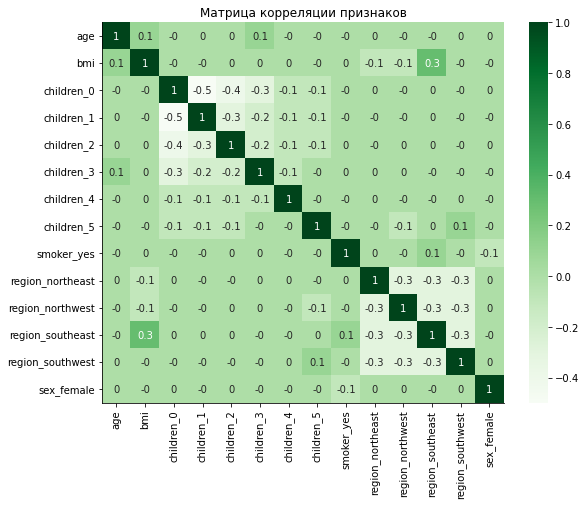

In [158]:
matrix = data.corr().applymap(lambda x: round(x,1))
fig, ax = plt.subplots(figsize=(9,7)) 
sns.heatmap(data=matrix, annot = True, ax=ax, cmap="Greens").set(title='Матрица корреляции признаков')
sns.despine()

    3. Сплитуем на тренировочную и тестовую выборки:

In [105]:
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=1)

    4. Создаем модель RandomForestRegressor (проверка на работоспособность):

In [176]:
%%time

rf = RandomForestRegressor(n_jobs=-1).fit(X_train, y_train)

Wall time: 94.6 ms


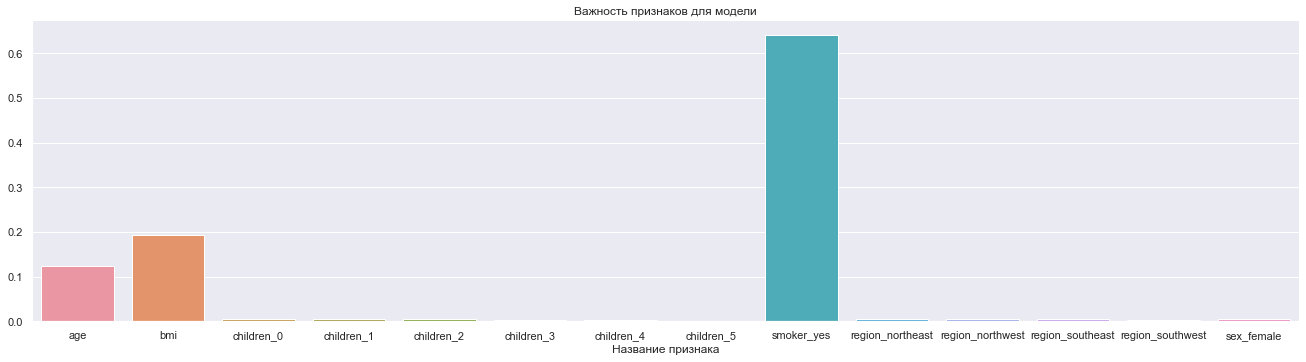

In [212]:
# Видим, что наиболее важные признаки для модели - возраст, индекс массы тела и является ли человек курильщиком:

sns.catplot(data=pd.DataFrame({'feature_name':data.columns, 
                               'feature_importances':rf.feature_importances_}),
            x='feature_name', y='feature_importances',kind="bar", aspect=3.7)\
   .set(title='Важность признаков для модели', xlabel='Название признака', ylabel='')

sns.despine()

    5. Смотрим на получающиеся метрики ошибок на тестовом наборе:

In [110]:
# Даже на оптимизированная модель показывает очень хорошие результаты:

pred = rf.predict(X_test)
print(f'RandomForestRegressor R²:       {round(rf.score(X_test, y_test),2)}')
print(f'RandomForestRegressor RMSE:  {round(np.sqrt(MSE(y_test, pred)),2)}')
print(f'RandomForestRegressor MAE:   {round(MAE(y_test, pred),2)}')
print(f'RandomForestRegressor MAPE:     {round(100*MAPE(y_test, pred),2)} %')

RandomForestRegressor R²:       0.86
RandomForestRegressor RMSE:  4402.88
RandomForestRegressor MAE:   2467.74
RandomForestRegressor MAPE:     30.33 %


     6. Проводим кросс-валидацию с решётчатым поиском для выявления оптимальных параметров модели:

In [75]:
%%time

parametrs = { 'n_estimators': range (100, 1000, 100),
              'max_depth': range (10,30, 3),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }

rf = RandomForestRegressor()
grid_rf = GridSearchCV(rf, parametrs, cv=5, n_jobs=-1, scoring='neg_mean_absolute_percentage_error')
grid_rf.fit(data, target)

Wall time: 14min 51s


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': range(10, 30, 3),
                         'min_samples_leaf': range(1, 8),
                         'min_samples_split': range(2, 10, 2),
                         'n_estimators': range(100, 1000, 100)},
             scoring='neg_mean_absolute_percentage_error')

In [112]:
# Лучше результаты кросс-валидации:

cv_results = pd.DataFrame(grid_rf.cv_results_)
cv_results['mean_test_score'] = -cv_results['mean_test_score']
cv_results.sort_values('mean_test_score').head(3)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
963,0.279438,0.017856,"{'max_depth': 19, 'min_samples_leaf': 6, 'min_..."
747,0.279904,0.017301,"{'max_depth': 16, 'min_samples_leaf': 7, 'min_..."
244,0.280118,0.019870,"{'max_depth': 10, 'min_samples_leaf': 7, 'min_..."


    7. Делаем вывод, что наиболее подходящая модель - RandomForestRegressor с параметрами:

In [113]:
grid_rf.best_params_

{'max_depth': 19,
 'min_samples_leaf': 6,
 'min_samples_split': 8,
 'n_estimators': 100}

    8. Усреднённые метрики ошибок модели:

In [149]:
best_params = grid_rf.best_params_

rf = RandomForestRegressor(**best_params, n_jobs=-1).fit(X_train, y_train)

print(f'R²: {round(np.mean(cross_val_score(rf, data, target, scoring="r2", cv=5, n_jobs=-1)),2)}')
print(f'MAE: {(-1)*int(np.mean(cross_val_score(rf, data, target, scoring="neg_mean_absolute_error", cv=5, n_jobs=-1)))}')
print(f'RMSE: {(-1)*int(np.mean(cross_val_score(rf, data, target, scoring="neg_root_mean_squared_error", cv=5, n_jobs=-1)))}')
print(f'MAPE: {round((-100)*np.mean(cross_val_score(rf, data, target, scoring="neg_mean_absolute_percentage_error",cv=5, n_jobs=-1)),1)} %')

R²: 0.86
MAE: 2496
RMSE: 4538
MAPE: 28.7 %


# Выводы:

1. Получена модель, имеющая усреднённые метрики ошибок:

***R²***: 0.86

***MAE***: 2496

***RMSE***: 4538

***MAPE***: 28.7 %

2. Выявлено, что наиболее важными признаками для предсказания являются: возраст, индекс массы тела и является ли клиент курильщиком.


3. Полученная модель может быть использована в боте на сайте страховой компании для автоматизации консультирования клиентов.